# Approximate Dynamic Programming

In [2]:
using Interact
using Grid
using PGFPlots
using Distributions
include("helpers.jl");

INFO: Precompiling module Grid.
INFO: Recompiling stale cache file /home/zach/.julia/lib/v0.5/Images.ji for module Images.
INFO: Recompiling stale cache file /home/zach/.julia/lib/v0.5/PGFPlots.ji for module PGFPlots.


## Function Approximation

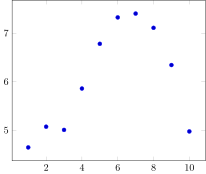

In [3]:
# Generate some random data
srand(0)
s = 1:10
u = 4 - 0.5 * s + 0.35 * s.^2 - 0.03 * s.^3 + rand(length(s))
Plots.Scatter(s, u)

In [4]:
# wrap the Grid.jl package function
function gridInterp(s, u, method)
    z = CoordInterpGrid(s, u, BCnearest, method)
    (s0) -> z[s0]
end;

Interact.Options{:ToggleButtons,Any}(Signal{Any}(Grid.InterpNearest, nactions=0),"method",Grid.InterpNearest,"Grid.InterpNearest",Interact.OptionDict(Any["Grid.InterpNearest","Grid.InterpLinear","Grid.InterpQuadratic"],Dict{Any,Any}(Pair{Any,Any}("Grid.InterpNearest",Grid.InterpNearest),Pair{Any,Any}("Grid.InterpQuadratic",Grid.InterpQuadratic),Pair{Any,Any}("Grid.InterpLinear",Grid.InterpLinear))),Any[],Any[])

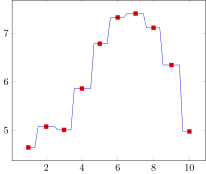

In [5]:
@manipulate for method in [InterpNearest, InterpLinear, InterpQuadratic]
Axis([
        Plots.Linear(gridInterp(s, u, method), (1,10)),
        Plots.Scatter(s, u)
    ])
end

In [6]:
function polyfitFunction(X, Y, order)
    λ = polyfit(X, Y, order) # polyfit in helpers.jl
    β(x) = [float(x)^p for p = 0:order]
    (x) -> dot(λ, β(x))
end

polyfitFunction (generic function with 1 method)

In [ ]:
@manipulate for order in 0:9
    title=prettyPolynomial(polyfit(s, u, order))
    Axis([
        Plots.Linear(polyfitFunction(s, u, order), (1,10)),
        Plots.Scatter(s, u),
        ], title=title)
end    

## Cross Entopy Method

In [10]:
# Example true function (has local optima)
V(λ) = 0.5*(exp(-(λ/2).^2) + 2 * exp(-((λ - 10)/2).^2) + 0.75 * exp(-((λ - 5)/2).^2));

In [11]:
# Note: this is designed for univariate functions (easy to generalize, though)
function crossEntropyMethod(f::Function, distribution; steps = 10, populationSize = 20, eliteSize = 5)
    while true
        # draw population of random samples from the distribution
        samples = rand(distribution, populationSize)
        # get the indices of the samples in decreasing order
        index = sortperm(map(f, samples), rev=true)
        # pull off the elite samples
        eliteSamples = samples[index[1:eliteSize]]
        if steps == 0
            return samples, eliteSamples, distribution
        else
            steps = steps - 1
        end
        # update the distribution based on the elite samples
        distribution = fit_mle(Normal, eliteSamples)
    end
end;

Interact.Slider{Int64}(Signal{Int64}(2, nactions=0),"steps",2,0:4,true)

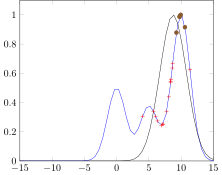

In [12]:
initialDistribution = Normal(0, 1)
domain = (-15,15)
@manipulate for steps = 0:4
    srand(0)
    (samples, eliteSamples, distribution) = crossEntropyMethod(λ->V(λ), Normal(0., 10.), steps = steps)
    densityScale = 1/pdf(distribution, distribution.μ)
    density = λ->densityScale*pdf(distribution, λ)
    Axis([
        Plots.Linear(V, domain),
        Plots.Scatter(samples, map(V, samples), mark="+"),
        Plots.Scatter(eliteSamples, map(V, eliteSamples)),
        Plots.Linear(density, domain)
        ], xmin=domain[1], xmax=domain[2], ymin=0
    )
end